Epoch 1/100
5701/5701 ━━━━━━━━━━━━━━━━━━━━ 86s 13ms/step - loss: 0.5390 - mae: 0.3830 - val_loss: 0.3229 - val_mae: 0.2743
Epoch 2/100
5701/5701 ━━━━━━━━━━━━━━━━━━━━ 69s 12ms/step - loss: 0.3292 - mae: 0.2937 - val_loss: 0.2386 - val_mae: 0.2177
Epoch 3/100
5701/5701 ━━━━━━━━━━━━━━━━━━━━ 83s 14ms/step - loss: 0.2254 - mae: 0.2186 - val_loss: 0.1739 - val_mae: 0.1746
Epoch 4/100
5701/5701 ━━━━━━━━━━━━━━━━━━━━ 82s 14ms/step - loss: 0.1854 - mae: 0.1894 - val_loss: 0.1505 - val_mae: 0.1563
Epoch 5/100
5701/5701 ━━━━━━━━━━━━━━━━━━━━ 71s 13ms/step - loss: 0.1669 - mae: 0.1772 - val_loss: 0.1359 - val_mae: 0.1473
Epoch 6/100
5701/5701 ━━━━━━━━━━━━━━━━━━━━ 60s 11ms/step - loss: 0.1522 - mae: 0.1675 - val_loss: 0.1328 - val_mae: 0.1563
Epoch 7/100
5701/5701 ━━━━━━━━━━━━━━━━━━━━ 62s 11ms/step - loss: 0.1435 - mae: 0.1619 - val_loss: 0.1173 - val_mae: 0.1338
Epoch 8/100
5701/5701 ━━━━━━━━━━━━━━━━━━━━ 72s 13ms/step - loss: 0.1342 - mae: 0.1551 - val_loss: 0.1114 - val_mae: 0.1378
Epoch 9/100
5701

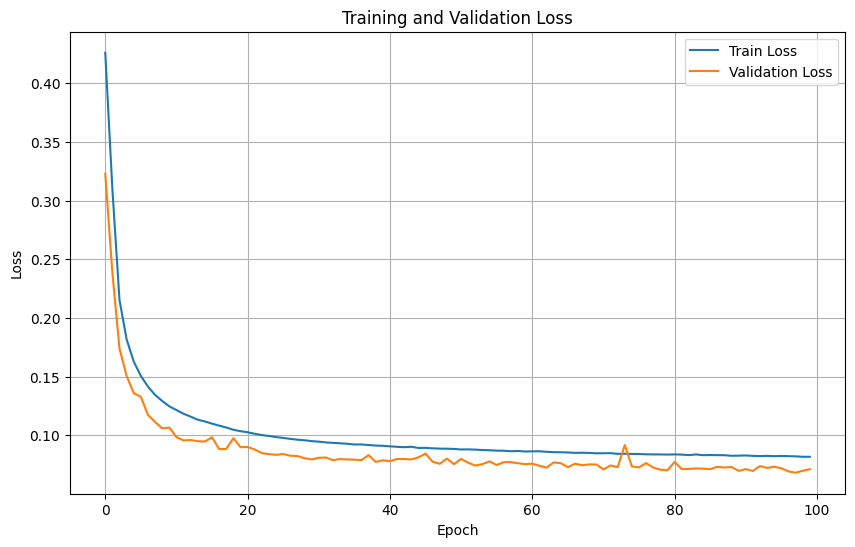

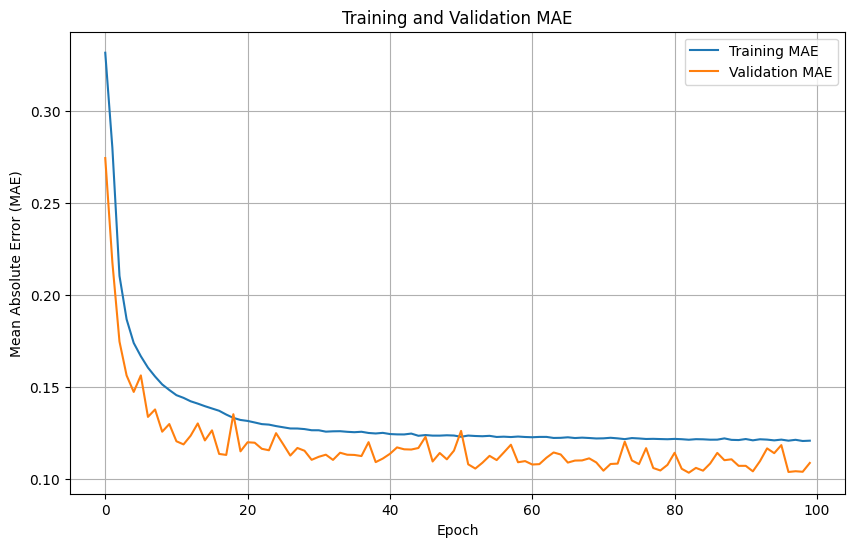

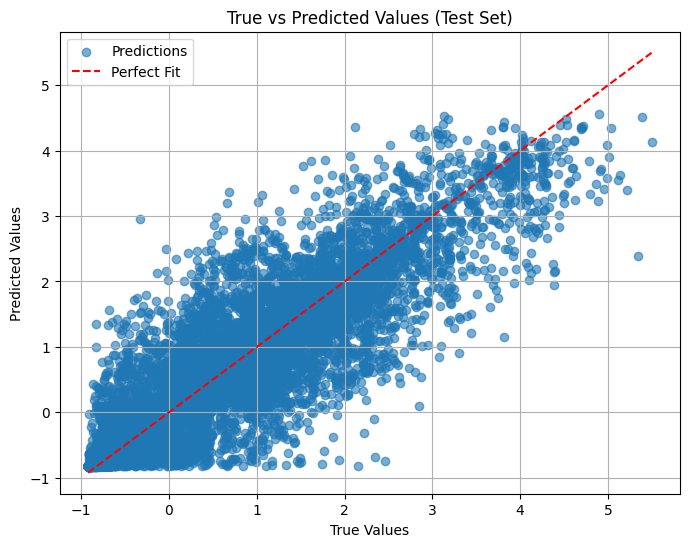

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load your dataset
df = pd.read_csv(r'C:\Users\sireg\OneDrive\Desktop\Artificial Intelligence\normalized_data.csv', sep=',', low_memory=False)

# Convert 'Datetime' column to datetime format if not already
df['Datetime'] = pd.to_datetime(df['Datetime'], errors='coerce')

# Feature Engineering: Extract additional features
df['Hour'] = df['Datetime'].dt.hour
df['Day_of_Week'] = df['Datetime'].dt.dayofweek  # Monday=0, Sunday=6
df['Day'] = df['Datetime'].dt.day
df['Minute'] = df['Datetime'].dt.minute
df['Day_Type'] = np.where(df['Day_of_Week'].isin([5, 6]), 'Weekend', 'Weekday')  # Mark weekends vs weekdays

# Select relevant features (including additional ones) for training
features = ["Global_active_power", "Global_intensity", "Sub_metering_1",
            "Sub_metering_2", "Sub_metering_3", "Hour", "Day_of_Week", "Day", "Minute"]
target = "Global_active_power"  # Target variable

# Standardizing the data (including additional features)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[features].values)

# Preparing dataset
seq_length = 30  # Sequence length (30 time steps)
X, y = [], []

# Prepare sequences and targets
for i in range(len(scaled_data) - seq_length):
    X.append(scaled_data[i:i + seq_length])
    y.append(scaled_data[i + seq_length, 0])  # Target is Global_active_power

X = np.array(X)
y = np.array(y)

# Train, validation, and test split
train_size = int(len(X) * 0.7)  # 70% training
val_size = int(len(X) * 0.1)    # 10% validation
test_size = len(X) - train_size - val_size  # Remaining 20% for testing

X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

learning_rate = 0.001  
batch_size = 32        
epochs = 100           
dropout_rate = 0.1     

# Build the Transformer model with a global attention mechanism
inputs = layers.Input(shape=(seq_length, X_train.shape[2]))  # (sequence_length, features)

# Transformer block with global attention
x = layers.MultiHeadAttention(num_heads=4, key_dim=64)(inputs, inputs)  # Self-attention
x = layers.Dropout(dropout_rate)(x)  
x = layers.LayerNormalization(epsilon=1e-6)(x)

# Add a global attention mechanism
attention_weights = layers.Dense(1, activation='tanh')(x)  # Generate raw attention scores
attention_weights = layers.Softmax(axis=1)(attention_weights)  # Normalize scores across time steps
attention_output = layers.Multiply()([x, attention_weights])  # Element-wise multiplication
attention_output = layers.GlobalAveragePooling1D()(attention_output)  # Aggregate over time steps

# Fully connected layers for regression
x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(attention_output)
outputs = layers.Dense(1, kernel_regularizer=regularizers.l2(0.01))(x)

model = models.Model(inputs=inputs, outputs=outputs)

# Compile the model with the consistent learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Train the model with consistent epochs and batch size
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)

# Predict on the test set
y_pred_test = model.predict(X_test)
y_pred_test = y_pred_test.flatten()

# Calculate performance metrics for the test set
test_mae = mean_absolute_error(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)

print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R-squared: {r2:.4f}")

# Visualize training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Visualize training and validation MAE
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.grid(True)
plt.show()

# Scatter plot: True vs. Predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=0.6, label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Fit')
plt.title('True vs Predicted Values (Test Set)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

# Save the model
model.save('transformer_with_global_attention_no_CNN.keras')
